In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import colorcet as cc
import cmasher as cmr

In [2]:
data_dir = '/Users/sofimar/Desktop/Observational Astro/Imaging/'

## Step 3

## Assess the RMS and mean levels of a bias image near the center of the CCD chip

In [3]:
img_file = fits.open(data_dir+'a099.fits')

img_header = img_file[0].header
img_data = img_file[0].data

Given that there are 2048 rows and 2200 columns, the midpoint of the image is at (1100,1024). I am choosing a small region of 14x14 pixels (I hate numbers that end in 0 or 5) around the midpoint.

In [4]:
img_patch = img_data[1092:1106,1016:1030]

In [5]:
np.shape(img_patch)

(14, 14)

### Computing mean of patch

In [6]:
mean = np.mean(img_patch)
print('Mean = ', mean)

Mean =  670.5867346938776


### Computing RMS

In [7]:
sqr = img_patch**2
mean_sqr = np.mean(sqr)
rms = np.sqrt(mean_sqr)
print('RMS = ', rms)

RMS =  219.54943425486812


### Making Plots!

I depict the values of a random row within the small region to see how much the values of the pixels in that row vary from the mean of the whole region

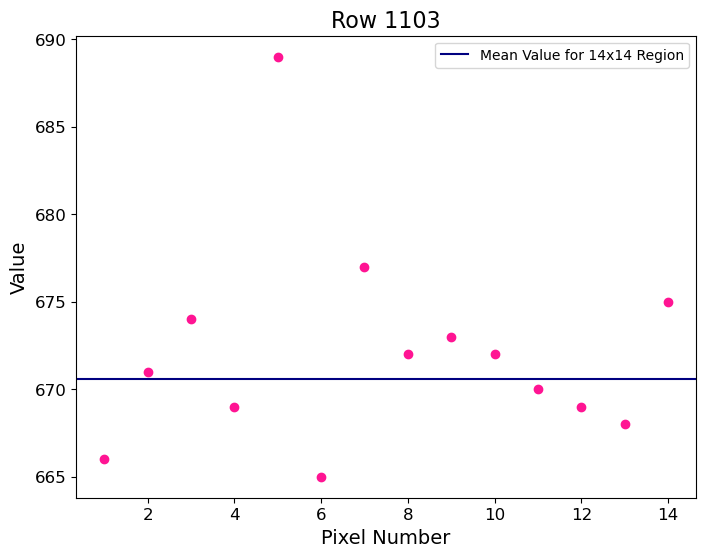

In [8]:
x = np.linspace(1,14,14)

plt.figure(figsize=(8,6))
plt.scatter(x, img_patch[9], color='deeppink')
plt.axhline(mean, color='navy', label='Mean Value for 14x14 Region')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Pixel Number', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.title('Row 1103', fontsize=16)
plt.legend()

# Step 5
## Examine overscan regions throughout the night

In [9]:
imgs = ImageFileCollection(data_dir,glob_include='a???.fits',glob_exclude='*ot*.fits')
imgs.summary

file,simple,bitpix,naxis,naxis1,naxis2,extend,bscale,bzero,origin,date,iraf-tlm,datamin,datamax,object,date-obs,timesys,observat,sidetime,objepoch,airmass,exptime,ha,telescop,instrume,filter1,filter2,telra,teldec,observer,comment
str9,bool,int64,int64,int64,int64,bool,float64,float64,str37,str19,str21,float64,float64,str7,str23,str3,str11,str10,float64,float64,float64,str9,str9,str10,str4,str4,str11,str12,str8,str19
a001.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:16,09:55:15 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:43:32.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,3.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a002.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:16,09:55:16 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:44:22.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,3.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a003.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:17,09:55:16 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:44:52.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a004.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:17,09:55:17 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:45:32.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a005.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:18,09:55:17 (15/09/2009),0.0,50846.0,SERVICE,2009-06-23T01:47:01.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a006.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:19,09:55:18 (15/09/2009),0.0,50217.0,SERVICE,2009-06-23T01:47:41.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a007.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:19,09:55:19 (15/09/2009),0.0,49940.0,SERVICE,2009-06-23T01:48:27.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a008.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:20,09:55:19 (15/09/2009),0.0,49115.0,SERVICE,2009-06-23T01:49:26.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"
a009.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:20,09:55:20 (15/09/2009),0.0,48778.0,SERVICE,2009-06-23T01:49:59.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None"


In [10]:
def data_opener(a,b,lst, d=3):
    for i in range(b-a):
        c = i+a+1
        if d==3:
            file_ = fits.open(data_dir+'/a'+str(c)+'.fits')
        if d==2:
            file_ = fits.open(data_dir+'/a0'+str(c)+'.fits')
        if d==1:
            file_ = fits.open(data_dir+'/a00'+str(c)+'.fits')
        file_data = file_[0].data
        lst.append(file_data)
        
    return lst


In [11]:
def os_avg(f):
    for i in range(2048):
        colsum1 = np.sum(f[i,0:53])
        colsum2 = np.sum(f[i,2102:])
        colsum = colsum1 + colsum2

        avg = colsum/(53+103)
    return avg
    

In [12]:
pgvals = []
ngcvals = []

data_opener(129,139, pgvals)

[array([[  0, 694, 699, ..., 661, 675, 657],
        [657, 664, 636, ..., 634, 662, 658],
        [668, 658, 622, ..., 660, 683, 659],
        ...,
        [654, 665, 627, ..., 642, 658, 659],
        [659, 655, 635, ..., 661, 631, 661],
        [657, 660, 631, ..., 655, 663, 657]], dtype=uint16),
 array([[  0, 696, 699, ..., 658, 662, 649],
        [659, 672, 634, ..., 680, 664, 662],
        [662, 658, 633, ..., 662, 662, 653],
        ...,
        [651, 658, 629, ..., 663, 664, 660],
        [660, 659, 634, ..., 660, 629, 659],
        [659, 656, 635, ..., 654, 658, 673]], dtype=uint16),
 array([[  0, 696, 699, ..., 657, 659, 638],
        [662, 659, 633, ..., 660, 666, 662],
        [661, 663, 634, ..., 679, 664, 664],
        ...,
        [661, 660, 632, ..., 658, 658, 659],
        [664, 664, 632, ..., 660, 656, 658],
        [660, 651, 629, ..., 658, 661, 656]], dtype=uint16),
 array([[  0, 695, 699, ..., 665, 662, 659],
        [660, 660, 652, ..., 665, 650, 659],
        [662,

In [13]:
data_opener(201,211, pgvals)
print(np.shape(pgvals))

(20, 2048, 2200)


In [14]:
data_opener(236,246, pgvals)
print(np.shape(pgvals))

(30, 2048, 2200)


In [15]:
data_opener(152,163, ngcvals)
print(np.shape(ngcvals))

(11, 2048, 2200)


In [16]:
flat313 = fits.open(data_dir+'/a035.fits')
f313_val = flat313[0].data
f313_os_avg = os_avg(f313_val)
f313_t = datetime(2009,6,22, 3,13)

pg650 = fits.open(data_dir+'/a130.fits')
p650_val = pg650[0].data
p650_os_avg = os_avg(p650_val)
p650_t = datetime(2009,6,22, 6,50)

ngc720 = fits.open(data_dir+'/a153.fits')
n720_val = ngc720[0].data
n720_os_avg = os_avg(n720_val)
n720_t = datetime(2009,6,22, 7,20)

pg818 = fits.open(data_dir+'/a202.fits')
p818_val = pg818[0].data
p818_os_avg = os_avg(p818_val)
p818_t = datetime(2009,6,22,8,18)

pg935 = fits.open(data_dir+'/a237.fits')
p935_val = pg935[0].data
p935_os_avg = os_avg(p935_val)
p935_t = datetime(2009,6,22,9,35)

avg = [f313_os_avg, p650_os_avg, n720_os_avg, p818_os_avg, p935_os_avg]
time = [f313_t, p650_t, n720_t, p818_t, p935_t]

Text(0, 0.5, 'Mean Value of Overscan')

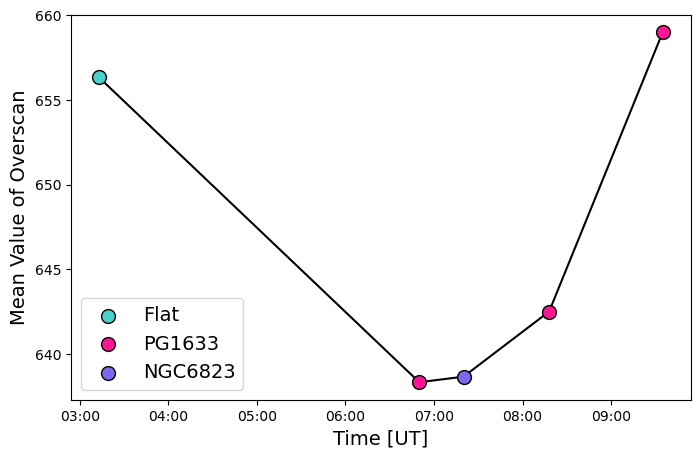

In [17]:
import matplotlib
fig,ax = plt.subplots(figsize=(8,5))
plt.plot(time,avg, color='black', zorder=0)
plt.scatter(time[0],avg[0], color='mediumturquoise', label='Flat', s=99, ec='black')
plt.scatter(time[1],avg[1], color='deeppink', label='PG1633',s=99, ec='black')
plt.scatter(time[2],avg[2], color='mediumslateblue', label='NGC6823', s=99, ec='black')
plt.scatter(time[3:], avg[3:], color='deeppink',s=99, ec='black')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
plt.legend(fontsize=14)
plt.xlabel('Time [UT]', fontsize=14)
plt.ylabel('Mean Value of Overscan', fontsize=14)

The mean value of the overscan is not constant throughout the night. Therefore, I would not recommend making a master bias and subtract that from the images. Instead, I propose using the overscan region of each individual frame as a way to estimate bias.

# Step 6
## Fitting, subtracting, and trimming

First, I'm going to test out the waters by performing overscan subtraction and trimming on one image.

In [18]:
# Models: Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
import astropy.units as u
test = fits.open(data_dir+'/a237.fits')
pix_vals = CCDData(test[0].data.astype(np.float64), unit=u.adu)

subtract_Poly = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=1))
subtract_Cheb = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=1))
subtract_Lege = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=1))
subtract_Herm = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=1))

subtract_Poly2 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=2))
subtract_Cheb2 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=2))
subtract_Lege2 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=2))
subtract_Herm2 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=2))

subtract_Poly3 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=3))
subtract_Cheb3 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=3))
subtract_Lege3 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=3))
subtract_Herm3 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=3))

subtract_Poly4 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=4))
subtract_Cheb4 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=4))
subtract_Lege4 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=4))
subtract_Herm4 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=4))

subtract_Poly5 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=5))
subtract_Cheb5 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=5))
subtract_Lege5 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=5))
subtract_Herm5 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=5))

subtract_Poly6 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=6))
subtract_Cheb6 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=6))
subtract_Lege6 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=6))
subtract_Herm6 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=6))

subtract_Poly7 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=7))
subtract_Cheb7 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=7))
subtract_Lege7 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=7))
subtract_Herm7 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=7))

subtract_Poly8 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Polynomial1D(degree=8))
subtract_Cheb8 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Chebyshev1D(degree=8))
subtract_Lege8 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Legendre1D(degree=8))
subtract_Herm8 = ccdp.subtract_overscan(pix_vals, overscan=pix_vals[:,2101:], model=Hermite1D(degree=8))


 [astropy.modeling.fitting]

 [astropy.modeling.fitting]

 [astropy.modeling.fitting]

 [astropy.modeling.fitting]

 [astropy.modeling.fitting]



In [19]:
polytrim = ccdp.trim_image(subtract_Poly, fits_section='[53:2102,:]')
chebtrim = ccdp.trim_image(subtract_Cheb, fits_section='[53:2102,:]')
legetrim = ccdp.trim_image(subtract_Lege, fits_section='[53:2102,:]')
hermtrim = ccdp.trim_image(subtract_Herm, fits_section='[53:2102,:]')

polytrim2 = ccdp.trim_image(subtract_Poly2, fits_section='[53:2102,:]')
chebtrim2 = ccdp.trim_image(subtract_Cheb2, fits_section='[53:2102,:]')
legetrim2 = ccdp.trim_image(subtract_Lege2, fits_section='[53:2102,:]')
hermtrim2 = ccdp.trim_image(subtract_Herm2, fits_section='[53:2102,:]')

polytrim3 = ccdp.trim_image(subtract_Poly3, fits_section='[53:2102,:]')
chebtrim3 = ccdp.trim_image(subtract_Cheb3, fits_section='[53:2102,:]')
legetrim3 = ccdp.trim_image(subtract_Lege3, fits_section='[53:2102,:]')
hermtrim3 = ccdp.trim_image(subtract_Herm3, fits_section='[53:2102,:]')

polytrim4 = ccdp.trim_image(subtract_Poly4, fits_section='[53:2102,:]')
chebtrim4 = ccdp.trim_image(subtract_Cheb4, fits_section='[53:2102,:]')
legetrim4 = ccdp.trim_image(subtract_Lege4, fits_section='[53:2102,:]')
hermtrim4 = ccdp.trim_image(subtract_Herm4, fits_section='[53:2102,:]')

polytrim5 = ccdp.trim_image(subtract_Poly5, fits_section='[53:2102,:]')
chebtrim5 = ccdp.trim_image(subtract_Cheb5, fits_section='[53:2102,:]')
legetrim5 = ccdp.trim_image(subtract_Lege5, fits_section='[53:2102,:]')
hermtrim5 = ccdp.trim_image(subtract_Herm5, fits_section='[53:2102,:]')

polytrim6 = ccdp.trim_image(subtract_Poly6, fits_section='[53:2102,:]')
chebtrim6 = ccdp.trim_image(subtract_Cheb6, fits_section='[53:2102,:]')
legetrim6 = ccdp.trim_image(subtract_Lege6, fits_section='[53:2102,:]')
hermtrim6 = ccdp.trim_image(subtract_Herm6, fits_section='[53:2102,:]')

polytrim7 = ccdp.trim_image(subtract_Poly7, fits_section='[53:2102,:]')
chebtrim7 = ccdp.trim_image(subtract_Cheb7, fits_section='[53:2102,:]')
legetrim7 = ccdp.trim_image(subtract_Lege7, fits_section='[53:2102,:]')
hermtrim7 = ccdp.trim_image(subtract_Herm7, fits_section='[53:2102,:]')

polytrim8 = ccdp.trim_image(subtract_Poly8, fits_section='[53:2102,:]')
chebtrim8 = ccdp.trim_image(subtract_Cheb8, fits_section='[53:2102,:]')
legetrim8 = ccdp.trim_image(subtract_Lege8, fits_section='[53:2102,:]')
hermtrim8 = ccdp.trim_image(subtract_Herm8, fits_section='[53:2102,:]')

In [20]:
def trim_avg_med(y, lst1, lst2):
    for i in range(8):
        avg_ = np.mean(y[i])
        med_ = np.median(y[i])
        lst1.append(avg_)
        lst2.append(med_)
    return lst1, lst2

In [21]:
polyavg = []
polymed = []
pdata = [polytrim[0].data, polytrim2[0].data, polytrim3[0].data, polytrim4[0].data, polytrim5[0].data,
polytrim6[0].data, polytrim7[0].data, polytrim8[0].data]

trim_avg_med(pdata,polyavg,polymed)

([43.13796740361539,
  43.096571586180104,
  43.0549198875887,
  43.05491990249362,
  43.05491990249362,
  43.05491990249362,
  43.05491990249362,
  43.05491990249362],
 [33.955040574347095,
  33.91364475691182,
  33.87199305832041,
  33.871993073225326,
  33.871993073225326,
  33.871993073225326,
  33.871993073225326,
  33.871993073225326])

In [22]:
chevavg = []
chevmed = []
cdata = [chebtrim[0].data, chebtrim2[0].data, chebtrim3[0].data, chebtrim4[0].data, chebtrim5[0].data,
chebtrim6[0].data, chebtrim7[0].data, chebtrim8[0].data]

trim_avg_med(cdata,chevavg,chevmed)


legavg = []
legmed = []
ldata = [legetrim[0].data, legetrim2[0].data, legetrim3[0].data, legetrim4[0].data, legetrim5[0].data,
legetrim6[0].data, legetrim7[0].data, legetrim8[0].data]

trim_avg_med(ldata,legavg,legmed)


heravg = []
hermed = []
hdata = [hermtrim[0].data, hermtrim2[0].data, hermtrim3[0].data, hermtrim4[0].data, hermtrim5[0].data,
hermtrim6[0].data, hermtrim7[0].data, hermtrim8[0].data]

trim_avg_med(hdata, heravg,hermed)

([43.1379674036155,
  43.096571586180346,
  43.05491988758893,
  43.02337985446165,
  42.961985740029085,
  42.94053552849373,
  42.91054533211871,
  42.90510235343384],
 [33.95504057434721,
  33.91364475691205,
  33.87199305832064,
  33.84045302519337,
  33.779058910760796,
  33.75760869922544,
  33.72761850285042,
  33.72217552416555])

(array([42.85, 42.9 , 42.95, 43.  , 43.05, 43.1 , 43.15]),
 [Text(0, 42.85, '42.85'),
  Text(0, 42.9, '42.90'),
  Text(0, 42.95, '42.95'),
  Text(0, 43.0, '43.00'),
  Text(0, 43.050000000000004, '43.05'),
  Text(0, 43.1, '43.10'),
  Text(0, 43.15, '43.15')])

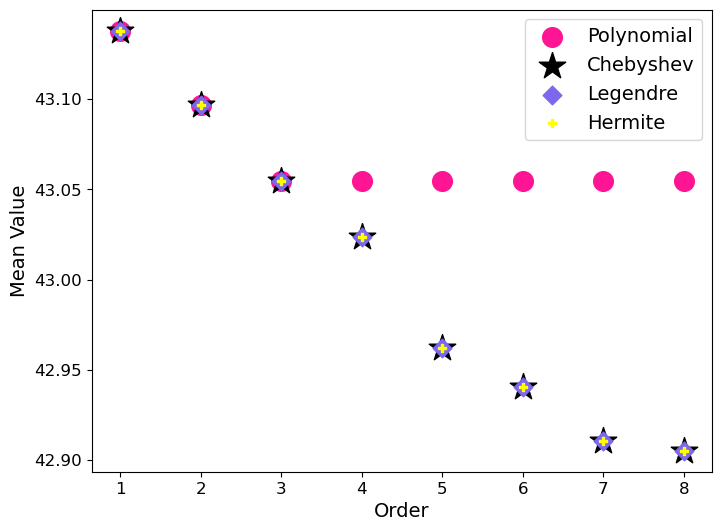

In [23]:
deg = np.linspace(1,8,8)

plt.figure(figsize=(8,6))
plt.scatter(deg, polyavg, color='deeppink', s=200, label='Polynomial')
plt.scatter(deg, chevavg, color='black', s=400, marker='*', label='Chebyshev')
plt.scatter(deg, legavg, color='mediumslateblue', s=90, marker='D', label='Legendre')
plt.scatter(deg, heravg, color='yellow', s=40, marker='P', label='Hermite')

plt.legend(fontsize=14)
plt.xlabel('Order', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

The Polynomial model plateaus at the third order, while the average pixel value continues to decrease in the other models after the third order. There aren't noticeable differences between the mean values across the Chebyshev, Legendre, and Hermite models of the same order. Additionally, the fifth, sixth, sventh, and eighth order values of these three models are within ~0.05 ADUs from one another. Therefore, I think using a fifth-order Chebyshev, Legendre, or Hermite model should suffice for performing overscan subtraction on the rest of the data. I will use a Hermite model because it's the easiest to spell.

In [35]:
# Doing it for all images
all_images = []

data_opener(129,139,all_images)
data_opener(152,163,all_images)
data_opener(201,211,all_images)
data_opener(236,246,all_images)

print(np.shape(all_images))

(41, 2048, 2200)


In [36]:
all_images_ccd = CCDData(all_images, unit=u.adu)
all_trim = []

for i in range(41):
    Herm5 = ccdp.subtract_overscan(all_images_ccd[i], overscan=pix_vals[:,2101:], model=Hermite1D(degree=5))
    Herm5trim = ccdp.trim_image(Herm5, fits_section='[53:2102,:]')
    all_trim.append(Herm5trim)

# Step 7

In [25]:
# 93-111
bias_ = []
data_opener(92,99, bias_, d=2)

[array([[687, 690, 686, ..., 659, 663, 658],
        [662, 659, 635, ..., 681, 645, 662],
        [658, 664, 635, ..., 673, 665, 655],
        ...,
        [659, 660, 633, ..., 664, 638, 659],
        [655, 662, 637, ..., 659, 670, 660],
        [670, 667, 639, ..., 644, 655, 668]], dtype=uint16),
 array([[693, 680, 688, ..., 655, 666, 656],
        [661, 661, 637, ..., 660, 631, 660],
        [661, 658, 635, ..., 661, 647, 654],
        ...,
        [646, 664, 637, ..., 662, 664, 663],
        [665, 660, 634, ..., 663, 662, 599],
        [651, 662, 639, ..., 664, 657, 667]], dtype=uint16),
 array([[686, 692, 687, ..., 634, 658, 663],
        [645, 659, 631, ..., 664, 659, 659],
        [663, 662, 636, ..., 662, 671, 649],
        ...,
        [664, 658, 611, ..., 662, 662, 663],
        [661, 664, 641, ..., 664, 664, 667],
        [645, 635, 632, ..., 663, 664, 661]], dtype=uint16),
 array([[682, 681, 687, ..., 674, 636, 654],
        [660, 661, 633, ..., 667, 665, 664],
        [661,

In [26]:
data_opener(99,111,bias_)

[array([[687, 690, 686, ..., 659, 663, 658],
        [662, 659, 635, ..., 681, 645, 662],
        [658, 664, 635, ..., 673, 665, 655],
        ...,
        [659, 660, 633, ..., 664, 638, 659],
        [655, 662, 637, ..., 659, 670, 660],
        [670, 667, 639, ..., 644, 655, 668]], dtype=uint16),
 array([[693, 680, 688, ..., 655, 666, 656],
        [661, 661, 637, ..., 660, 631, 660],
        [661, 658, 635, ..., 661, 647, 654],
        ...,
        [646, 664, 637, ..., 662, 664, 663],
        [665, 660, 634, ..., 663, 662, 599],
        [651, 662, 639, ..., 664, 657, 667]], dtype=uint16),
 array([[686, 692, 687, ..., 634, 658, 663],
        [645, 659, 631, ..., 664, 659, 659],
        [663, 662, 636, ..., 662, 671, 649],
        ...,
        [664, 658, 611, ..., 662, 662, 663],
        [661, 664, 641, ..., 664, 664, 667],
        [645, 635, 632, ..., 663, 664, 661]], dtype=uint16),
 array([[682, 681, 687, ..., 674, 636, 654],
        [660, 661, 633, ..., 667, 665, 664],
        [661,

In [27]:
np.shape(bias_)

(19, 2048, 2200)

In [28]:
bias_ = np.array(bias_)
bias__ = CCDData(bias_, unit=u.adu)
print(np.shape(bias__))

master_bias = ccdp.combine(bias__)

(19, 2048, 2200)


In [29]:
master_bias[0].data

array([682.47368421, 687.36842105, 687.63157895, ..., 656.57894737,
       659.57894737, 658.05263158])

/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_19510/1000108607.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bmw = get_cmap('cet_bmw')


Text(0.5, 1.0, 'Master Bias')

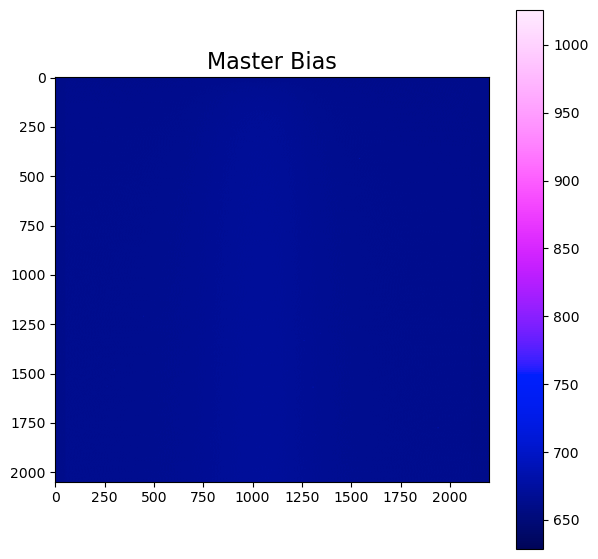

In [46]:
bmw = get_cmap('cet_bmw')

fig = plt.subplots(1,1,figsize=(7,7))
plt.imshow(master_bias, cmap=bmw)
plt.colorbar()
plt.title('Master Bias', fontsize=16)

In [40]:
np.max(master_bias)

1025.578947368421

In [43]:
np.mean(master_bias)

masked_array(data=665.59844553,
             mask=False,
       fill_value=1e+20)

In [44]:
np.median(master_bias)

/Users/sofimar/opt/anaconda3/envs/astr8060/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


665.2105263157895

Although the image of the master bias appears uniform, there must be single outlier pixels since the maximum value of the master bias is around 1025.6 ADUs while both the average and the median values are around 665 ADUs. I still think it's better to remove the bias by subtracting the overscan region of each individual frame because as shown in Step 5, the overscan varies throughout the night.

# Step 8
## Darks

In [47]:
drk_num = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015']
drk_avg = []
drk_med = []
exp_t = []

for i in range(len(drk_num)):
    dark = fits.open(data_dir+'/d'+drk_num[i]+'.fits')
    
    dark_pix = dark[0].data
    davg = np.mean(dark_pix)
    drk_avg.append(davg)
    dmed = np.median(dark_pix)
    drk_med.append(dmed)

    dark_hdr = dark[0].header
    exp_t.append(dark_hdr['EXPTIME'])


(array([655., 656., 657., 658., 659., 660., 661.]),
 [Text(0, 655.0, '655'),
  Text(0, 656.0, '656'),
  Text(0, 657.0, '657'),
  Text(0, 658.0, '658'),
  Text(0, 659.0, '659'),
  Text(0, 660.0, '660'),
  Text(0, 661.0, '661')])

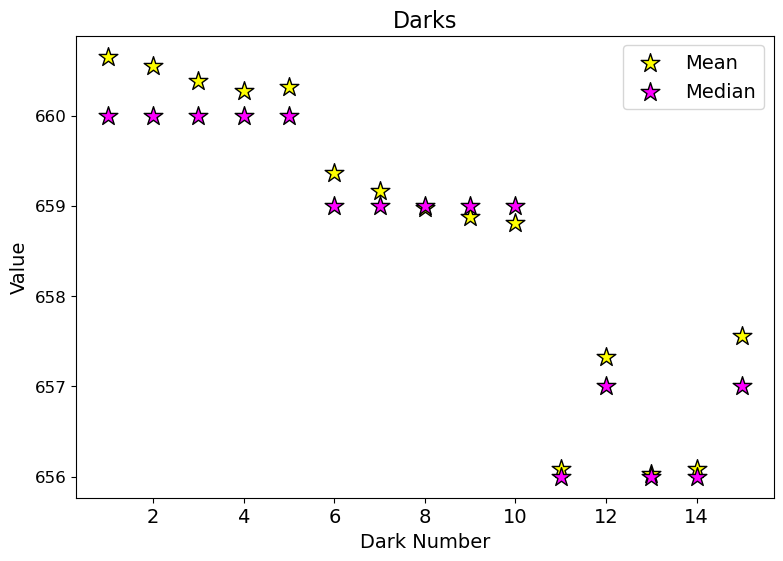

In [48]:
x = np.linspace(1,15,15)

plt.figure(figsize=(9,6))
plt.scatter(x,drk_avg, marker='*', s=200, color='yellow', label='Mean', ec='black')
plt.scatter(x, drk_med,marker='*', s=200, color='magenta', label='Median', ec='black')
plt.legend(fontsize=14)
plt.title('Darks', fontsize=16)
plt.xlabel('Dark Number', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

The median yields more uniform values than the average. I think using the median instead of the average is better for combining the images into one master bias because cosmic rays are likely to skew the average since they spread light over small clusters of pixels unlike single pixels with high levels of dark current.

### Estimate dark current range

In [49]:
G = 2.5 #e/ADU
drk_med = np.array(drk_med)
exp_t = np.array(exp_t)
dc = (G*drk_med)/exp_t

print('Dark Current Range Estimate = ','(', np.min(dc),',', np.max(dc),')')

Dark Current Range Estimate =  ( 5.466666666666667 , 825.0 )


Text(0, 0.5, 'Dark Current [e$^{-}$/pix/s]')

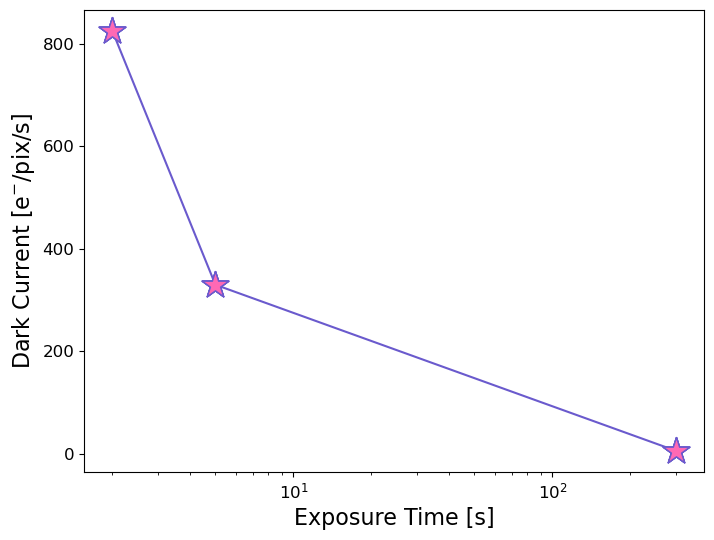

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(exp_t, dc, marker='*', s=400, color='hotpink', ec='slateblue')
plt.plot(exp_t, dc, color='slateblue', zorder=0)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Exposure Time [s]', fontsize=16)
plt.ylabel('Dark Current [e$^{-}$/pix/s]', fontsize=16)

# Step 9
## Make master dark

In [51]:
drk_list = []
for i in range(15):
    d = fits.open(data_dir+'/d'+drk_num[i]+'.fits')
    dpix = CCDData(d[0].data, unit=u.adu)
    drk_list.append(dpix)

In [52]:
davg = ccdp.combine(drk_list)
dmed = ccdp.combine(drk_list, method='median')

In [53]:
davg_3s = ccdp.combine(drk_list, sigma_clip=True)
dmed_3s = ccdp.combine(drk_list, method='median', sigma_clip=True)

In [54]:
def rms(md):
    mdarray = md[0].data
    mdavg = np.mean(mdarray**2)
    rms_ = np.sqrt(mdavg)
    return rms_

In [66]:
print('Method', ' ', '         ','RMS', '                 Max')
print('Mean:             ', rms(davg), '  ', np.max(davg))
print('Median:           ', rms(dmed), '   ', np.max(dmed))
print('Mean & 3sigma:    ', rms(davg_3s), '   ', np.max(davg_3s))
print('Median & 3sigma:  ',rms(dmed_3s), '  ', np.max(dmed_3s))

Method             RMS                  Max
Mean:              653.0330258946257    1830.0
Median:            653.038826981562     675.0
Mean & 3sigma:     652.993974111273     674.8
Median & 3sigma:   653.0374609886828    675.0


The RMS of all methods is about 653. However, the maximum value of the master dark produced by the mean is almost three times as big as the maximum values of the rest of the master darks computed from median and sigma clipping methods. If we assume that the typical dark current is 653 ADUs, WIRO's gain is 2.5 electrons/ADU, and light spreads over 4 pixels, then the noise will be about 81. Therefore, the typical current is about 8 time bigger than the noise.


Overall, I think the best method is the median and 3sigma combo because it takes into account two statistical tools that limit the influence of cosmic rays when combining frames.